In [1]:
!pip install pandas kagglehub seaborn matplotlib scikit-learn torch lightly

  Using cached kagglehub-0.3.12-py3-none-any.whl.metadata (38 kB)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached lightly-1.5.20-py3-none-any.whl.metadata (37 kB)
  Using cached hydra_core-1.3.2-py3-none-any.whl.metadata (5.5 kB)
  Using cached lightly_utils-0.0.2-py3-none-any.whl.metadata (1.4 kB)
  Using cached pytorch_lightning-2.5.1.post0-py3-none-any.whl.metadata (20 kB)
  Using cached aenum-3.1.16-py3-none-any.whl.metadata (3.8 kB)
  Using cached omegaconf-2.3.0-py3-none-any.whl.metadata (3.9 kB)
  Using cached antlr4_python3_runtime-4.9.3-py3-none-any.whl
  Using cached torchmetrics-1.7.1-py3-none-any.whl.metadata (21 kB)
  Using cached lightning_utilities-0.14.3-py3-none-any.whl.metadata (5.6 kB)
Using cached kagglehub-0.3.12-py3-none-any.whl (67 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached lightly-1.5.20-py3-none-any.whl (851 kB)
Using cached aenum-3.1.16-py3-none-any.whl (165 kB)
Using cached hydra_core-1.3.2-py3-none-

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn.decomposition import PCA

from lightly.loss import NTXentLoss


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import os # For file path joining
import kagglehub
import time

/opt/conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Download latest version
PATH = kagglehub.dataset_download("ellipticco/elliptic-data-set")
print("Path to dataset files:", PATH)


Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/ellipticco/elliptic-data-set/versions/1


In [4]:
N_FEATURES = 166  # Time step + 165 features
EMBEDDING_DIM = 256
ENCODER_EMBEDDING_DIM = 256
PROJECTION_DIM = 64
BATCH_SIZE = 256 
EPOCHS = 10 
LEARNING_RATE = 1e-3 
TEMPERATURE = 0.1

AUG_NOISE_LEVEL = 0.03
AUG_MASK_FRACTION = 0.15

In [5]:

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

Using device: cuda


In [6]:
print("Loading Elliptic dataset...")
try:
    classes_df = pd.read_csv(PATH + "/elliptic_bitcoin_dataset/elliptic_txs_classes.csv")
    features_df = pd.read_csv(PATH + "/elliptic_bitcoin_dataset/elliptic_txs_features.csv")
    edge_df = pd.read_csv(PATH + "/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv")

    # print(classes_df.head(), end="\n\n")
    # print(features_df.head(), end="\n\n")
    # print(edge_df.head())
except FileNotFoundError:

    print(f"Error: Dataset files not found in {PATH}")
    print("Please download the Elliptic dataset and place it in the correct directory,")
    print("or update the DATA_DIR variable.")
    exit()

Loading Elliptic dataset...


In [7]:
#Assign feature headers (txId, Time step, f1 to f165)
feature_headers = ['txId', 'Time step'] + [f'f{i}' for i in range(1, 166)]
features_df.columns = feature_headers
print(features_df.columns)

df = pd.merge(features_df, classes_df, on='txId', how='left')

# Map classes for evaluation: 1 (illicit) -> 1, 2 (licit) -> 0, unknown -> NaN
df['class'] = df['class'].map({'1': 1, '2': 0})

# Separate features (X) and labels (y)
# Features: Time step + f1 to f165
X_cols = ['Time step'] + [f'f{i}' for i in range(1, 166)]
X_all = df[X_cols].values
y_all = df['class'].values # Contains NaN for unknowns

Index(['txId', 'Time step', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8',
       ...
       'f156', 'f157', 'f158', 'f159', 'f160', 'f161', 'f162', 'f163', 'f164',
       'f165'],
      dtype='object', length=167)


In [8]:
# Identify known labels for evaluation later
known_indices = df.index[df['class'].notna()].tolist()
y_known = df.loc[known_indices, 'class'].values.astype(int)
txId_known = df.loc[known_indices, 'txId'].values # Keep track of txId if needed

print(f"Total transactions: {len(df)}")
print(f"Transactions with known labels: {len(known_indices)}")
print(f"Illicit (1): {np.sum(y_known == 1)}, Licit (0): {np.sum(y_known == 0)}")

Total transactions: 203768
Transactions with known labels: 46564
Illicit (1): 4545, Licit (0): 42019


In [9]:
# Scale features (fit only on training data, but here we apply to all for unsupervised)
print("Scaling features...")
scaler = StandardScaler()
X_all_scaled = scaler.fit_transform(X_all)

Scaling features...


In [10]:
class EllipticDataset(Dataset):
    def __init__(self, features):
        self.features = torch.tensor(features, dtype=torch.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return single view for simplified contrastive loss
        return self.features[idx]



In [11]:
class EllipticDatasetAugmented(Dataset):
    def __init__(self, features, noise_level=0.05, mask_fraction=0.15):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.noise_level = noise_level
        self.mask_fraction = mask_fraction
        self.n_features = features.shape[1]
        print(f"Augmented Dataset Config: Noise Level={self.noise_level}, Mask Fraction={self.mask_fraction}")

    def __len__(self):
        return len(self.features)

    def _augment(self, x):
        # Apply noise
        noise = torch.randn_like(x) * self.noise_level
        x_noisy = x + noise
        # Apply masking
        # Create mask on the same device as x for efficiency if x is already on GPU in some contexts
        mask = torch.rand(self.n_features, device=x.device) > self.mask_fraction
        x_masked = x_noisy * mask
        return x_masked

    def __getitem__(self, idx):
        original_x = self.features[idx]
        # Create two different augmentations of the same sample
        view1 = self._augment(original_x.clone()) # Use clone to avoid modifying original tensor
        view2 = self._augment(original_x.clone())
        return view1, view2 # Return two views

In [12]:
# # Use all data for unsupervised training
# dataset = EllipticDataset(X_all_scaled)
# # drop_last=True is important for the artificial pairing in contrastive_loss
# dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, drop_last=True)

print("Setting up Training DataLoader with AUGMENTATION...")
train_dataset = EllipticDatasetAugmented(X_all_scaled, noise_level=AUG_NOISE_LEVEL, mask_fraction=AUG_MASK_FRACTION)
# Use drop_last=True if your batch size doesn't perfectly divide the dataset size
# Increase num_workers if data loading is a bottleneck (start with 2 or 4)
dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, pin_memory=True if DEVICE=='cuda' else False)

# Use the SIMPLE dataset for the evaluation dataloader - KEEP THIS
print("Setting up Evaluation DataLoader WITHOUT augmentation...")
eval_dataset = EllipticDataset(X_all_scaled)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE * 2, shuffle=False, num_workers=2)

Setting up Training DataLoader with AUGMENTATION...
Augmented Dataset Config: Noise Level=0.03, Mask Fraction=0.15
Setting up Evaluation DataLoader WITHOUT augmentation...


In [13]:
class CNNGRUEncoder(nn.Module):
    def __init__(self, input_dim, cnn_channels1=32, cnn_channels2=64, cnn_channels3=128, cnn_channels4=256,
                 kernel_size=9, pool_kernel=2,
                 gru_hidden_size=128, gru_layers=4, bidirectional=True,
                 embedding_dim=64):
        super(CNNGRUEncoder, self).__init__()
        self.input_dim = input_dim
        self.conv1 = nn.Conv1d(1, cnn_channels1, kernel_size, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(pool_kernel)
        self.conv2 = nn.Conv1d(cnn_channels1, cnn_channels2, kernel_size, padding='same')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(pool_kernel)
        self.conv3 = nn.Conv1d(cnn_channels2, cnn_channels3, kernel_size, padding='same')
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool1d(pool_kernel)
        self.conv4 = nn.Conv1d(cnn_channels3, cnn_channels4, kernel_size, padding='same')
        self.relu4 = nn.ReLU()
        # self.pool3 = nn.MaxPool1d(pool_kernel)

        l_out1 = math.floor(input_dim / pool_kernel)
        l_out2 = math.floor(l_out1 / pool_kernel)
        l_out3 = math.floor(l_out2 / pool_kernel)
        l_out4 = math.floor(l_out3 / pool_kernel)
        self.cnn_output_length = l_out4
        self.cnn_output_channels = cnn_channels4

        self.gru = nn.GRU(self.cnn_output_channels, gru_hidden_size, gru_layers,
                          batch_first=True, bidirectional=bidirectional)
        
        gru_output_dim = gru_hidden_size * (2 if bidirectional else 1)
        self.fc_out = nn.Linear(gru_output_dim, embedding_dim)
        print(f"CNN Output Sequence Length: {self.cnn_output_length}, Channels: {self.cnn_output_channels}")

        
    def forward(self, x):
        x = x.unsqueeze(1)
        # x = self.pool1(self.relu1(self.conv1(x)))
        # x = self.pool2(self.relu2(self.conv2(x)))
        # x = self.pool3(self.relu3(self.conv3(x)))
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.relu3(self.conv3(x))
        x = self.relu4(self.conv4(x))
        x = x.permute(0, 2, 1)
        _, h_n = self.gru(x)
        if self.gru.bidirectional:
            gru_out = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)
        else:
            gru_out = h_n[-1,:,:]
        embedding = self.fc_out(gru_out)
        embedding = F.normalize(embedding, p=2, dim=1)
        return embedding

In [14]:
class ProjectionHead(nn.Module):
    def __init__(self, input_dim=ENCODER_EMBEDDING_DIM, hidden_dim=ENCODER_EMBEDDING_DIM, output_dim=PROJECTION_DIM):
        super(ProjectionHead, self).__init__()
        # Simple 2-layer MLP as projection head
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        print(f"Projection Head: Input={input_dim}, Hidden={hidden_dim}, Output={output_dim}")

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        # Note: NTXentLoss often includes normalization internally, or you can add it here
        # x = F.normalize(x, p=2, dim=1) # Optional normalization here
        return x

In [15]:
# Instantiate encoder
encoder = CNNGRUEncoder(input_dim=N_FEATURES, embedding_dim=EMBEDDING_DIM).to(DEVICE)
encoder = torch.compile(encoder) # Compile the model after creating it
optimizer = optim.Adam(encoder.parameters(), lr=LEARNING_RATE)
print("\nCNN-GRU Encoder Architecture:")
print(encoder)

CNN Output Sequence Length: 10, Channels: 256

CNN-GRU Encoder Architecture:
OptimizedModule(
  (_orig_mod): CNNGRUEncoder(
    (conv1): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=same)
    (relu1): ReLU()
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=same)
    (relu2): ReLU()
    (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=same)
    (relu3): ReLU()
    (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=same)
    (relu4): ReLU()
    (gru): GRU(256, 128, num_layers=4, batch_first=True, bidirectional=True)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
  )
)


In [16]:
def contrastive_loss(z, temperature):
    """
    Optimized implementation of NT-Xent loss using logsumexp.
    Assumes z = torch.cat([view1, view2], dim=0)
    where view1 and view2 have shape (B, D) and B is the batch size.
    """
    n = z.shape[0] # Shape is (2*B, D)
    if n < 2:
        # Handle edge case where batch size is too small after drop_last
        return torch.tensor(0.0, device=z.device, requires_grad=True)
    batch_size = n // 2 # The original batch size B

    # Calculate cosine similarity matrix (2B x 2B)
    # Normalize features first is equivalent to cosine similarity for matrix mult
    z_norm = F.normalize(z, p=2, dim=1)
    sim_matrix = torch.mm(z_norm, z_norm.t()) # (2B, D) @ (D, 2B) -> (2B, 2B)
    # Or using the function directly:
    #sim_matrix = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)


    # Scale similarities by temperature
    logits = sim_matrix / temperature

    # --- Identify positive pairs ---
    # Create labels identifying samples across the two views
    labels = torch.arange(batch_size).to(z.device) # 0 to B-1
    # Create a mask for positive pairs: (i, i+B) and (i+B, i)
    mask_pos = torch.zeros_like(logits, dtype=torch.bool)
    mask_pos[torch.arange(batch_size), torch.arange(batch_size) + batch_size] = True
    mask_pos[torch.arange(batch_size) + batch_size, torch.arange(batch_size)] = True

    # Extract the logits corresponding to positive pairs
    # These are the sim(z1_k, z2_k)/T and sim(z2_k, z1_k)/T terms
    positives = logits[mask_pos].view(n, 1) # Shape: (2B, 1)

    # --- Calculate LogSumExp over negatives ---
    # Mask out self-similarity (diagonal) for the logsumexp calculation
    mask_self = torch.eye(n, dtype=torch.bool).to(z.device)
    logits_masked = logits.masked_fill(mask_self, -float('inf')) # Exclude sim(i,i)

    # Calculate logsumexp across all other samples (negatives + the other positive)
    logsumexp_all = torch.logsumexp(logits_masked, dim=1, keepdim=True) # Shape: (2B, 1)

    # --- Calculate final loss ---
    # loss = log(sum(exp(negatives))) - positive_similarity
    loss_per_sample = logsumexp_all - positives

    # Average loss over all 2B samples (both views)
    loss = loss_per_sample.mean()

    return loss

In [17]:
scaler = torch.cuda.amp.GradScaler(enabled=(DEVICE == torch.device('cuda')))

# Instantiate BOTH models
encoder = CNNGRUEncoder(input_dim=N_FEATURES, embedding_dim=ENCODER_EMBEDDING_DIM).to(DEVICE)
projection_head = ProjectionHead(input_dim=ENCODER_EMBEDDING_DIM, output_dim=PROJECTION_DIM).to(DEVICE)

# Compile if desired (compile both or just encoder if projection is simple)
encoder = torch.compile(encoder)
projection_head = torch.compile(projection_head)

optimizer = optim.Adam(
    list(encoder.parameters()) + list(projection_head.parameters()), # Combine parameters
    lr=LEARNING_RATE,
    weight_decay=1e-6
)

# Use the library loss function (operates on projection head output)
criterion = NTXentLoss(temperature=TEMPERATURE, memory_bank_size=0)

print("\nCNN-GRU Encoder Architecture:")
print(encoder)
print("\nProjection Head Architecture:")
print(projection_head)


# --- 6. Training Loop (Modified for Projection Head) ---
print("\nStarting Unsupervised Training with CNN-GRU Encoder + Projection Head")
losses = []
gradient_check_interval = 600 # Or disable if not needed

for epoch in range(EPOCHS):
    # --- Set BOTH models to training mode ---
    encoder.train()
    projection_head.train()
    # --- Init timers and loss tracking ---
    total_data_time = 0
    total_forward_time =0 
    total_backward_time=0
    total_loss_calc_time =0
    total_optimizer_step_time =0
    total_grad_check_time = 0
    epoch_loss = 0.0
    batches_processed = 0
    epoch_start_time = time.time()
    # ... (initialize other timer variables) ...
    batch_start_time = time.time()

    data_iterator = enumerate(dataloader) # Assumes Augmented Dataloader

    for batch_idx, (view1, view2) in data_iterator:
        data_end_time = time.time(); total_data_time += (data_end_time - batch_start_time)
        t0 = time.time()
        if view1.shape[0] < 2: batch_start_time = time.time(); continue
        view1, view2 = view1.to(DEVICE), view2.to(DEVICE)

        # --- Forward Pass & Loss Calculation within Autocast ---
        with torch.amp.autocast(device_type='cuda', dtype=torch.float16, enabled=(DEVICE == torch.device('cuda'))):
            t1 = time.time()
            # 1. Get ENCODER embeddings
            z1_enc = encoder(view1)
            z2_enc = encoder(view2)
            # 2. Get PROJECTION HEAD embeddings
            p1 = projection_head(z1_enc)
            p2 = projection_head(z2_enc)
            t2 = time.time()
            total_forward_time += (t2 - t1)

            # 3. --- Calculate Loss on PROJECTION output ---
            loss = criterion(p1, p2) # Use p1, p2 from projection head
            # --------------------------------------------
            t3 = time.time()
            total_loss_calc_time += (t3 - t2)

        # --- Backpropagation, Grad Check, Optimizer Step ---
        optimizer.zero_grad(set_to_none=True)

        if torch.isnan(loss) or torch.isinf(loss):
             print(f"Warning: NaN/Inf loss detected at Epoch {epoch+1}, Batch {batch_idx}. Skipping.")
             batch_start_time = time.time(); continue
        else:
            # 1. Backward Pass (Scaled) - Gradients flow back through proj head AND encoder
            t4 = time.time()
            scaler.scale(loss).backward()
            t5 = time.time()
            total_backward_time += (t5 - t4)

            # 2. Optional Gradient Checking (Checks grads in BOTH models now)
            t_gc_start = time.time()
            print_grads_this_batch = (batch_idx + 1) % gradient_check_interval == 0
            if print_grads_this_batch:
                 # --- (Gradient check block - unchanged, iterates encoder.named_parameters()) ---
                 # You could modify it to iterate list(encoder.named_parameters()) + list(projection_head.named_parameters())
                 # But checking the encoder alone is usually sufficient indicator
                 pass # Placeholder for grad check block if used
            t_gc_end = time.time()
            if print_grads_this_batch: total_grad_check_time += (t_gc_end - t_gc_start)


            # 3. Optimizer Step (Unscales gradients, updates BOTH models)
            t6 = time.time()
            # Optional: Clip gradients before step if needed
            # scaler.unscale_(optimizer) # Unscale first if clipping
            # torch.nn.utils.clip_grad_norm_(list(encoder.parameters()) + list(projection_head.parameters()), max_norm=1.0)
            scaler.step(optimizer)
            scaler.update()
            t7 = time.time()
            total_optimizer_step_time += (t7 - t6)

            # Accumulate loss and count batches
            epoch_loss += loss.item()
            batches_processed += 1


        # Print progress periodically
        if (batch_idx + 1) % 200 == 0:
             if 'loss' in locals() and loss is not None :
                 print(f"Epoch [{epoch+1}/{EPOCHS}], Batch [{batch_idx+1}/{len(dataloader)}], Current Loss: {loss.item():.4f}")

        batch_start_time = time.time() # Reset for next data load time


    # --- End of Epoch Summary ---
    # ... (Print epoch summary and timings as before) ...
    # losses.append(avg_epoch_loss)
    avg_epoch_loss = epoch_loss / batches_processed
    losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] Summary (Loss Type: NTXentLoss w/ Proj Head):\n")
    # ...

# --- 8. Generate Embeddings for ALL data ***USING ONLY THE ENCODER*** ---
print("\nGenerating final embeddings for all data (Using ENCODER Output)...")
# --- Set BOTH models to eval mode ---
encoder.eval()
projection_head.eval() # Set proj head to eval mode too (best practice)

all_embeddings_list = []
with torch.no_grad():
    # Use the SIMPLE dataset (eval_dataloader)
    for data in eval_dataloader:
        data = data.to(DEVICE)
        # *** GET EMBEDDINGS FROM ENCODER ONLY ***
        embeddings = encoder(data)
        # * DO NOT PASS THROUGH projection_head HERE *
        all_embeddings_list.append(embeddings.cpu().numpy())

# ... (Concatenate embeddings as before) ...
if all_embeddings_list:
     all_embeddings = np.concatenate(all_embeddings_list, axis=0)
     all_embeddings = all_embeddings[:len(eval_dataset)]
     print(f"Generated ENCODER embeddings shape: {all_embeddings.shape}") # Should be (N, ENCODER_EMBEDDING_DIM)
else:
     print("Error: No embeddings generated.")
     all_embeddings = None



CNN Output Sequence Length: 10, Channels: 256
Projection Head: Input=256, Hidden=256, Output=64

CNN-GRU Encoder Architecture:
OptimizedModule(
  (_orig_mod): CNNGRUEncoder(
    (conv1): Conv1d(1, 32, kernel_size=(9,), stride=(1,), padding=same)
    (relu1): ReLU()
    (pool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2): Conv1d(32, 64, kernel_size=(9,), stride=(1,), padding=same)
    (relu2): ReLU()
    (pool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3): Conv1d(64, 128, kernel_size=(9,), stride=(1,), padding=same)
    (relu3): ReLU()
    (pool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv4): Conv1d(128, 256, kernel_size=(9,), stride=(1,), padding=same)
    (relu4): ReLU()
    (gru): GRU(256, 128, num_layers=4, batch_first=True, bidirectional=True)
    (fc_out): Linear(in_features=256, out_features=256, bias=True)
  )
)

Projection Head Architecture:
Optimiz

In [18]:
num_trainable_params = sum(p.numel() for p in encoder.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in encoder.parameters())

print(f"Number of trainable parameters in encoder: {num_trainable_params:,}")
print(f"Total parameters in encoder: {total_params:,}")

# weights = encoder.state_dict()
# print("Saving model weights...")
# print("model weights are:", weights)

Number of trainable parameters in encoder: 1,639,424
Total parameters in encoder: 1,639,424


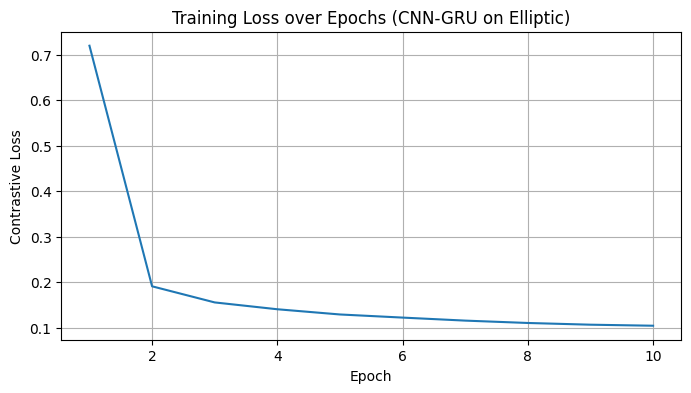

In [19]:
#Plot loss
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(losses) + 1), losses) # Adjust x-axis range based on actual epochs run
plt.title("Training Loss over Epochs (CNN-GRU on Elliptic)")
plt.xlabel("Epoch")
plt.ylabel("Contrastive Loss")
plt.grid(True)
plt.savefig("elliptic_training_loss_cnngru.png") # Save the plot
plt.show()

In [20]:
print("Generating final embeddings for all data...")
encoder.eval()
all_embeddings_list = []
# Use a dataloader for all data, no shuffling, potentially larger batch
eval_dataset = EllipticDataset(X_all_scaled)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE * 2, shuffle=False)

with torch.no_grad():
    for data in eval_dataloader:
        data = data.to(DEVICE)
        embeddings = encoder(data)
        all_embeddings_list.append(embeddings.cpu().numpy())

all_embeddings = np.concatenate(all_embeddings_list, axis=0)
print(f"Generated embeddings shape: {all_embeddings.shape}")

# Ensure embeddings count matches original data count
if len(all_embeddings) != len(df):
    print(f"Warning: Embedding count ({len(all_embeddings)}) does not match dataframe rows ({len(df)}). Check dataloading.")
    # Attempt to truncate if slightly off due to batching, but investigate if large difference
    all_embeddings = all_embeddings[:len(df)]

Generating final embeddings for all data...
Generated embeddings shape: (203768, 256)


In [21]:
# from sklearn.neighbors import NearestNeighbors
# import matplotlib.pyplot as plt
# import numpy as np

# # k = min_samples
# K_FOR_EPS_GRAPH = 5 #should roughly match DBSCAN_MIN_SAMPLES

# if all_embeddings is not None and len(all_embeddings) > 0:
#     print(f"\n--- Calculating k-distance graph for eps estimation (k={K_FOR_EPS_GRAPH}) ---")
#     # Ensure data is float32
#     if all_embeddings.dtype != np.float32:
#          all_embeddings = all_embeddings.astype(np.float32)

#     # Use NearestNeighbors to find distances
#     # Use 'cosine' metric since embeddings are normalized
#     print("Starting")
#     neighbors = NearestNeighbors(n_neighbors=K_FOR_EPS_GRAPH, metric='cosine', n_jobs=-1)
#     try:
#         neighbors_fit = neighbors.fit(all_embeddings)
#         distances, indices = neighbors_fit.kneighbors(all_embeddings)

#         # Get the distance to the k-th neighbor (k-th column, index k-1)
#         k_distances = np.sort(distances[:, K_FOR_EPS_GRAPH-1], axis=0)

#         # Plot the k-distance graph
#         plt.figure(figsize=(10, 6))
#         plt.plot(k_distances)
#         plt.title(f'{K_FOR_EPS_GRAPH}-distance Graph (Sorted)')
#         plt.xlabel("Points (sorted by distance)")
#         plt.ylabel(f'{K_FOR_EPS_GRAPH}-th Nearest Neighbor Distance (Cosine)')
#         plt.grid(True)
#         print(f"Plotting k-distance graph. Look for the 'elbow' point to estimate 'eps'.")
#         plt.savefig("dbscan_k_distance_graph.png")
#         plt.show()

#     except MemoryError:
#         print("  Error: Ran out of memory calculating nearest neighbors. Dataset might be too large for this analysis without subsampling.")
#     except Exception as e:
#         print(f"  An error occurred during k-distance calculation: {e}")
# else:
#     print("Skipping k-distance graph calculation as embeddings are not available.")


In [22]:
# predicted_anomalies_known = None # Store predictions ONLY for the known subset

# # Select the embeddings corresponding to known labels
# if all_embeddings is not None and len(known_indices) > 0:
#     embeddings_known = all_embeddings[known_indices]
#     if embeddings_known.dtype != np.float32:
#         embeddings_known = embeddings_known.astype(np.float32)

#     print(f"\n--- Applying Anomaly Detection ONLY to Labeled Subset ({len(known_indices)} points) ---")
#     print(f"Embeddings shape for detection: {embeddings_known.shape}")

#     # --- Choose ONE algorithm to test here (e.g., DBSCAN) ---

#     # --- Example: DBSCAN on Labeled Subset ---
#     # NOTE: 'eps' value suitable for the full dataset might NOT be suitable for the subset!
#     # You might need to re-run k-distance plot analysis JUST on embeddings_known
#     DBSCAN_EPS_SUBSET = 0.05 # EXAMPLE - TUNE THIS based on k-distance plot of embeddings_known
#     DBSCAN_MIN_SAMPLES_SUBSET = 10 # EXAMPLE - TUNE THIS

#     print(f"\n--- Starting DBSCAN on Labeled Subset (eps={DBSCAN_EPS_SUBSET}, min_samples={DBSCAN_MIN_SAMPLES_SUBSET}) ---")
#     start_time = time.time()
#     try:
#         dbscan_subset = DBSCAN(eps=DBSCAN_EPS_SUBSET,
#                                min_samples=DBSCAN_MIN_SAMPLES_SUBSET,
#                                metric='cosine',
#                                n_jobs=-1)
#         print("Fitting DBSCAN model on subset...")
#         cluster_labels_subset = dbscan_subset.fit_predict(embeddings_known)
#         end_time = time.time()
#         print(f"DBSCAN fitting on subset completed in {end_time - start_time:.2f} seconds.")

#         noise_count_subset = np.sum(cluster_labels_subset == -1)
#         print(f"Number of outliers found in subset: {noise_count_subset} ({noise_count_subset / len(embeddings_known) * 100:.2f}%)")

#         # Predictions are directly for the known set
#         predicted_anomalies_known = (cluster_labels_subset == -1).astype(int)

#     except Exception as e:
#         print(f"\n--- An unexpected error occurred during DBSCAN on subset: {e} ---")
#         predicted_anomalies_known = None

#     # --- OR Example: Isolation Forest on Labeled Subset
#     # ISO_FOREST_CONTAMINATION_SUBSET = 'auto' # Or e.g., 0.10 (illicit rate within known is ~10%)
#     # print(f"\n--- Starting Isolation Forest on Labeled Subset (contamination='{ISO_FOREST_CONTAMINATION_SUBSET}') ---")
#     # start_time = time.time()
#     # try:
#     #     iso_forest_subset = IsolationForest(n_estimators=100, contamination=ISO_FOREST_CONTAMINATION_SUBSET, random_state=42, n_jobs=-1)
#     #     preds_iso_subset = iso_forest_subset.fit_predict(embeddings_known)
#     #     end_time = time.time()
#     #     print(f"IsoForest fitting on subset completed in {end_time - start_time:.2f} seconds.")
#     #     predicted_anomalies_known = np.where(preds_iso_subset == -1, 1, 0)
#     #     n_anomalies_found = np.sum(predicted_anomalies_known)
#     #     print(f"Number of outliers found in subset: {n_anomalies_found} ({n_anomalies_found / len(embeddings_known) * 100:.2f}%)")
#     # except Exception as e:
#     #     print(f"\n--- An unexpected error occurred during Isolation Forest on subset: {e} ---")
#     #     predicted_anomalies_known = None


# else:
#     print("\nSkipping anomaly detection as embeddings or known indices are not available.")


# # --- 10. Evaluation (using predictions directly from the labeled subset run) ---
# print("\n--- Evaluating results from anomaly detection on labeled subset ---")

# if predicted_anomalies_known is None:
#     print("Anomaly detection on subset failed or was skipped. Cannot evaluate.")
# elif len(y_known) != len(predicted_anomalies_known):
#      print(f"Error: Length mismatch between true labels ({len(y_known)}) and predictions ({len(predicted_anomalies_known)}).")
# elif len(y_known) == 0:
#      print("No known labels available to evaluate against.")
# else:
#     # True labels: y_known
#     # Predicted: predicted_anomalies_known
#     # --- (Standard Evaluation Metrics Calculation - Keep as before) ---
#     accuracy = accuracy_score(y_known, predicted_anomalies_known)
#     # ... (calculate precision, recall, f1, auroc using y_known and predicted_anomalies_known) ...
#     # ... (print classification report) ...
#     precision, recall, f1, _ = precision_recall_fscore_support(y_known, predicted_anomalies_known, average='binary', pos_label=1, zero_division=0)
#     try:
#         if len(np.unique(y_known)) > 1 and len(np.unique(predicted_anomalies_known)) > 1: auroc = roc_auc_score(y_known, predicted_anomalies_known)
#         else: print("AUROC requires multiple classes in both true/pred. Skipping."); auroc = float('nan')
#     except ValueError as e: print(f"Could not calculate AUROC: {e}"); auroc = float('nan')
#     print(f"\nAccuracy (Subset): {accuracy:.4f}")
#     print(f"AUROC (Subset): {auroc:.4f}") # <<<--- CHECK THIS
#     print(f"Precision (Illicit): {precision:.4f}")
#     print(f"Recall (Illicit): {recall:.4f}")
#     print(f"F1-Score (Illicit): {f1:.4f}")
#     print("\nClassification Report (Subset):")
#     print(classification_report(y_known, predicted_anomalies_known, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))


In [23]:
# print("\n--- Evaluating on known licit/illicit transactions ---")

# if predicted_anomalies_all is None:
#     print("Clustering/Anomaly detection failed or was skipped. Cannot evaluate.")
# elif len(known_indices) == 0:
#      print("No known labels available in the dataset to evaluate against.")
# else:
#     # Select predictions corresponding to known labels
#     predicted_anomalies_known = predicted_anomalies_all[known_indices]
#     # Make sure it handles cases where predicted_anomalies_known might be empty if known_indices was empty
#     if len(predicted_anomalies_known) == 0:
#          print("No predictions available for known labels. Cannot evaluate.")
#     else:
#         accuracy = accuracy_score(y_known, predicted_anomalies_known)
#         precision, recall, f1, _ = precision_recall_fscore_support(y_known, predicted_anomalies_known, average='binary', pos_label=1, zero_division=0) # Focus on illicit class (1)
#         try:
#             if len(np.unique(y_known)) > 1 and len(np.unique(predicted_anomalies_known)) > 1:
#                  auroc = roc_auc_score(y_known, predicted_anomalies_known)
#             else:
#                  print("AUROC requires multiple classes in both true labels and predictions. Skipping AUROC calculation.")
#                  auroc = float('nan')
#         except ValueError as e:
#             print(f"Could not calculate AUROC: {e}")
#             auroc = float('nan')
#         print(f"\nAccuracy (known): {accuracy:.4f}")
#         print(f"AUROC (known): {auroc:.4f}")
#         print(f"Precision (for illicit=1): {precision:.4f}")
#         print(f"Recall (for illicit=1): {recall:.4f}")
#         print(f"F1-Score (for illicit=1): {f1:.4f}")
#         print("\nClassification Report (known):")
#         print(classification_report(y_known, predicted_anomalies_known, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))



In [24]:
# from sklearn.ensemble import IsolationForest # Import Isolation Forest
# # N_CLUSTER =
# # --- Configuration for Anomaly Detection ---
# # Hyperparameter for Isolation Forest: Expected proportion of outliers.
# # 'auto' lets the algorithm estimate, or set a value like 0.05, 0.10 etc.
# # Estimating based on known illicit rate: ~4545 / 203768 = ~0.022
# ISO_FOREST_CONTAMINATION = 0.05 # Or try 0.025, 0.05, 0.1

# # --- Ensure all_embeddings is defined from previous steps ---
# # all_embeddings = ... (Result from Section 8)

# # --- 9. Anomaly Detection using Isolation Forest ---

# predicted_anomalies_all = None
# # Note: Isolation Forest doesn't produce cluster labels like KMeans/DBSCAN
# # It produces anomaly scores or direct outlier predictions (-1/1).

# if all_embeddings is not None and len(known_indices) > 0:
#     # Ensure data is float32
#     embeddings_known = all_embeddings[known_indices]
#     if all_embeddings.dtype != np.float32:
#         print("Converting embeddings to float32...")
#         embeddings_known = embeddings_known.astype(np.float32)

#     print(f"\n--- Starting Isolation Forest Anomaly Detection ---")
#     print(f"Input embeddings shape: {embeddings_known.shape}")
#     print(f"Using IsolationForest with contamination='{ISO_FOREST_CONTAMINATION}'")

#     start_time = time.time()
#     try:
#         # n_estimators: Number of trees in the forest
#         # max_samples: Number of samples to draw to train each tree ('auto' is 256 or n_samples)
#         # contamination: Expected proportion of outliers (adjust based on results)
#         iso_forest = IsolationForest(n_estimators=100, # Default, can increase (e.g., 200)
#                                      max_samples='auto',
#                                      contamination=ISO_FOREST_CONTAMINATION,
#                                      random_state=42, # For reproducibility
#                                      n_jobs=-1)     # Use all available CPU cores

#         print("Fitting Isolation Forest model and predicting outliers...")
#         # fit_predict returns 1 for inliers (normal) and -1 for outliers (anomalous)
#         preds_iso = iso_forest.fit_predict(embeddings_known)

#         end_time = time.time()
#         print(f"Isolation Forest fitting and prediction completed in {end_time - start_time:.2f} seconds.")

#         # Convert predictions: -1 (outlier) -> 1 (anomaly), 1 (inlier) -> 0 (normal)
#         predicted_anomalies_all = np.where(preds_iso == -1, 1, 0)

#         n_anomalies_found = np.sum(predicted_anomalies_all)
#         print(f"\nNumber of predicted anomalies (outliers by Isolation Forest): {n_anomalies_found} ({n_anomalies_found / len(embeddings_known) * 100:.2f}%)")

#         # Optional: Get anomaly scores if needed for more nuanced thresholding later
#         # anomaly_scores = iso_forest.decision_function(all_embeddings) # Lower score means more anomalous
#         # score_threshold = np.percentile(anomaly_scores, 5) # Example: Threshold at 5th percentile score
#         # predicted_anomalies_all_score = (anomaly_scores < score_threshold).astype(int)


#     except MemoryError:
#         print("\n--- ERROR: Ran out of memory during Isolation Forest fitting! ---")
#         print("Check system resources. max_samples might need adjustment if using very large datasets.")
#         predicted_anomalies_all = None

#     except Exception as e:
#         print(f"\n--- An unexpected error occurred during Isolation Forest: {e} ---")
#         predicted_anomalies_all = None
# else:
#     print("\nSkipping Isolation Forest as embeddings were not generated.")


# # --- 10. Evaluation (using predicted_anomalies_all from Isolation Forest if successful) ---
# print("\n--- Evaluating on known licit/illicit transactions (Isolation Forest results) ---")

# if predicted_anomalies_all is None: # Check if Isolation Forest ran successfully
#     print("Anomaly detection failed or was skipped. Cannot evaluate.")
# elif len(known_indices) == 0:
#      print("No known labels available in the dataset to evaluate against.")
# else:
#     # Select predictions corresponding to known labels
#     # predicted_anomalies_known = predicted_anomalies_all[known_indices]

#     # True labels: y_known (0=licit/normal, 1=illicit/anomaly)
#     # Predicted: predicted_anomalies_known (0=normal/inlier, 1=anomaly/outlier)

#     if len(predicted_anomalies_known) == 0:
#          print("No predictions available for known labels. Cannot evaluate.")
#     else:
#         # --- (Standard Evaluation Metrics Calculation - Keep as before) ---
#         accuracy = accuracy_score(y_known, predicted_anomalies_known)
#         precision, recall, f1, _ = precision_recall_fscore_support(y_known, predicted_anomalies_known, average='binary', pos_label=1, zero_division=0)
#         try:
#             if len(np.unique(y_known)) > 1 and len(np.unique(predicted_anomalies_known)) > 1: auroc = roc_auc_score(y_known, predicted_anomalies_known)
#             else: print("AUROC requires multiple classes in both true/pred. Skipping."); auroc = float('nan')
#         except ValueError as e: print(f"Could not calculate AUROC: {e}"); auroc = float('nan')

#         print(f"\nAccuracy (known): {accuracy:.4f}")
#         print(f"AUROC (known): {auroc:.4f}") # <<<--- CHECK THIS METRIC
#         print(f"Precision (for illicit=1): {precision:.4f}")
#         print(f"Recall (for illicit=1): {recall:.4f}")
#         print(f"F1-Score (for illicit=1): {f1:.4f}")
#         print("\nClassification Report (known):")
#         print(classification_report(y_known, predicted_anomalies_known, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))


# # --- Final Notes ---
# # ... (Keep final notes as before) ...

In [25]:
# --- Keep necessary imports ---
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
import time
# ... (other imports like os, kagglehub if needed for data loading) ...

# --- Assume previous sections have run successfully ---
# 1. Data Loading (features_df, classes_df merged into df)
# 2. Feature Scaling (X_all_scaled created)
# 3. Label Preparation (known_indices, y_known created)
# --- Required variables from previous steps: ---
# X_all_scaled: Numpy array of all scaled features (N_samples, N_features)
# known_indices: List or array of indices corresponding to labeled data
# y_known: Numpy array of true labels (0 or 1) for the known data

# --- Supervised Baseline using RandomForest ---

print("\n--- Starting Supervised Baseline Training (RandomForest) ---")

if 'X_all_scaled' not in locals() or 'known_indices' not in locals() or 'y_known' not in locals():
    print("Error: Prerequisite data (X_all_scaled, known_indices, y_known) not found. Ensure data loading and prep ran.")
    # Handle error appropriately, maybe exit()
    exit()
elif len(known_indices) == 0:
    print("Error: No known labels available for supervised training.")
    exit()
else:
    # Select the features and labels for the known data
    X_known_scaled = X_all_scaled[known_indices]
    # y_known is already defined

    print(f"Using {len(y_known)} labeled samples for training and testing.")
    print(f"Feature shape: {X_known_scaled.shape}")

    # Split the labeled data into training and testing sets
    # stratify=y_known ensures similar class proportions in train/test sets
    try:
        X_train, X_test, y_train, y_test = train_test_split(
            X_known_scaled,
            y_known,
            test_size=0.3,       # Use 30% for testing
            random_state=42,   # For reproducibility
            stratify=y_known   # Important for imbalanced data
        )
        print(f"Train set size: {len(y_train)}, Test set size: {len(y_test)}")
        print(f"Illicit in train: {np.sum(y_train==1)}, Illicit in test: {np.sum(y_test==1)}")

    except ValueError as e:
         print(f"Error during train_test_split (potentially too few samples of one class for stratification): {e}")
         exit()


    # Initialize RandomForestClassifier
    # Hyperparameters can be tuned, these are reasonable defaults
    # class_weight='balanced' helps with imbalanced data
    rf_classifier = RandomForestClassifier(
        n_estimators=150,      # Number of trees
        max_depth=20,          # Limit tree depth to prevent overfitting (tune this)
        random_state=42,
        n_jobs=-1,             # Use all CPU cores
        class_weight='balanced' # Important for imbalanced classes
        # min_samples_leaf=5   # Can also help prevent overfitting
    )

    # Train the model
    print("\nTraining RandomForest model...")
    start_time = time.time()
    rf_classifier.fit(X_train, y_train)
    end_time = time.time()
    print(f"RandomForest training completed in {end_time - start_time:.2f} seconds.")

    # Make predictions on the test set
    print("\nMaking predictions on the test set...")
    y_pred_rf = rf_classifier.predict(X_test)
    # Get probability predictions for AUROC calculation
    # Predict probability of the positive class (illicit=1)
    y_pred_proba_rf = rf_classifier.predict_proba(X_test)[:, 1]

    # Evaluate the results
    print("\n--- Supervised RandomForest Evaluation Results ---")
    accuracy_rf = accuracy_score(y_test, y_pred_rf)
    precision_rf, recall_rf, f1_rf, _ = precision_recall_fscore_support(y_test, y_pred_rf, average='binary', pos_label=1, zero_division=0)

    try:
        # Check if both classes are present in y_test for AUROC
        if len(np.unique(y_test)) > 1:
             auroc_rf = roc_auc_score(y_test, y_pred_proba_rf) # Use probabilities for AUROC
        else:
             print("AUROC requires multiple classes in y_test. Skipping AUROC calculation.")
             auroc_rf = float('nan')
    except ValueError as e:
        print(f"Could not calculate AUROC: {e}")
        auroc_rf = float('nan')

    print(f"Accuracy (RF): {accuracy_rf:.4f}")
    print(f"AUROC (RF):    {auroc_rf:.4f}") # <<<--- THIS IS THE KEY BASELINE METRIC
    print(f"Precision (for illicit=1): {precision_rf:.4f}")
    print(f"Recall (for illicit=1):    {recall_rf:.4f}")
    print(f"F1-Score (for illicit=1):  {f1_rf:.4f}")

    print("\nClassification Report (RF - Test Set):")
    print(classification_report(y_test, y_pred_rf, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))

    # Optional: Feature Importance
    importances = rf_classifier.feature_importances_
    feature_names = X_cols # From data loading section
    importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
    importance_df = importance_df.sort_values('importance', ascending=False)
    print("\nTop 10 Feature Importances:")
    print(importance_df.head(10))

# --- Rest of your script (if any) ---


--- Starting Supervised Baseline Training (RandomForest) ---
Using 46564 labeled samples for training and testing.
Feature shape: (46564, 166)
Train set size: 32594, Test set size: 13970
Illicit in train: 3181, Illicit in test: 1364

Training RandomForest model...
RandomForest training completed in 5.32 seconds.

Making predictions on the test set...

--- Supervised RandomForest Evaluation Results ---
Accuracy (RF): 0.9872
AUROC (RF):    0.9944
Precision (for illicit=1): 0.9933
Recall (for illicit=1):    0.8746
F1-Score (for illicit=1):  0.9302

Classification Report (RF - Test Set):
              precision    recall  f1-score   support

   Licit (0)       0.99      1.00      0.99     12606
 Illicit (1)       0.99      0.87      0.93      1364

    accuracy                           0.99     13970
   macro avg       0.99      0.94      0.96     13970
weighted avg       0.99      0.99      0.99     13970


Top 10 Feature Importances:
    feature  importance
55      f55    0.049547
53  

In [26]:
from sklearn.linear_model import LogisticRegression # Use Logistic Regression as probe
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_fscore_support
import time

print("\n--- Evaluating Learned Embeddings with Linear Probe (Logistic Regression) ---")

# Ensure embeddings and known labels/indices are available from previous steps
if 'all_embeddings' != None and 'known_indices' in locals() and 'y_known' in locals() and len(known_indices) > 0:

    # Select the embeddings corresponding to known labels
    embeddings_known = all_embeddings[known_indices]
    # y_known holds the true labels (0 or 1)

    print(f"Using {len(y_known)} labeled samples for linear probe.")
    print(f"Embedding shape for probe: {embeddings_known.shape}")

    # Split labeled embeddings into train/test for the probe
    try:
        X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
            embeddings_known,  # Use the learned embeddings as features
            y_known,
            test_size=0.3,     # Use 30% for testing the probe
            random_state=42,
            stratify=y_known   # Stratify based on the true labels
        )
        print(f"Linear Probe: Train size={len(y_train_emb)}, Test size={len(y_test_emb)}")

        # Initialize and Train the Linear Probe (Logistic Regression)
        # Using scaled data (embeddings) often benefits logistic regression
        # Consider adding a scaler here if embeddings aren't already well-behaved,
        # though normalization in encoder might suffice.
        scaler_probe = StandardScaler()
        X_train_emb = scaler_probe.fit_transform(X_train_emb)
        X_test_emb = scaler_probe.transform(X_test_emb)

        # Use class_weight='balanced' for logistic regression too
        linear_probe = LogisticRegression(
            solver='liblinear', # Good solver for smaller datasets / binary classification
            random_state=42,
            class_weight='balanced',
            max_iter=100
            # C=1.0 # Regularization strength (can tune)
            )

        print("\nTraining Linear Probe (Logistic Regression)...")
        start_time = time.time()
        linear_probe.fit(X_train_emb, y_train_emb)
        end_time = time.time()
        print(f"Linear probe training completed in {end_time - start_time:.2f} seconds.")

        # Evaluate the probe on the test set
        print("\nEvaluating Linear Probe on the test set...")
        y_pred_probe = linear_probe.predict(X_test_emb)
        # Get probabilities for AUROC
        y_pred_proba_probe = linear_probe.predict_proba(X_test_emb)[:, 1]

        # Calculate metrics
        accuracy_probe = accuracy_score(y_test_emb, y_pred_probe)
        precision_probe, recall_probe, f1_probe, _ = precision_recall_fscore_support(y_test_emb, y_pred_probe, average='binary', pos_label=1, zero_division=0)
        try:
            if len(np.unique(y_test_emb)) > 1:
                 auroc_probe = roc_auc_score(y_test_emb, y_pred_proba_probe)
            else: auroc_probe = float('nan')
        except ValueError as e: print(f"Could not calculate AUROC: {e}"); auroc_probe = float('nan')

        print("\n--- Linear Probe Evaluation Results ---")
        print(f"Accuracy (Probe): {accuracy_probe:.4f}")
        print(f"AUROC (Probe):    {auroc_probe:.4f}") # <<<--- KEY RESULT
        print(f"Precision (Illicit): {precision_probe:.4f}")
        print(f"Recall (Illicit):    {recall_probe:.4f}")
        print(f"F1-Score (Illicit):  {f1_probe:.4f}")
        print("\nClassification Report (Probe - Test Set):")
        print(classification_report(y_test_emb, y_pred_probe, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))

    except ValueError as e:
        print(f"Error during train/test split or evaluation for linear probe: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during linear probe evaluation: {e}")

else:
    print("\nSkipping Linear Probe evaluation as embeddings or known labels are not available.")



--- Evaluating Learned Embeddings with Linear Probe (Logistic Regression) ---
Using 46564 labeled samples for linear probe.
Embedding shape for probe: (46564, 256)
Linear Probe: Train size=32594, Test size=13970

Training Linear Probe (Logistic Regression)...
Linear probe training completed in 19.61 seconds.

Evaluating Linear Probe on the test set...

--- Linear Probe Evaluation Results ---
Accuracy (Probe): 0.9261
AUROC (Probe):    0.9658
Precision (Illicit): 0.5814
Recall (Illicit):    0.8695
F1-Score (Illicit):  0.6968

Classification Report (Probe - Test Set):
              precision    recall  f1-score   support

   Licit (0)       0.99      0.93      0.96     12606
 Illicit (1)       0.58      0.87      0.70      1364

    accuracy                           0.93     13970
   macro avg       0.78      0.90      0.83     13970
weighted avg       0.95      0.93      0.93     13970



In [27]:
# --- Keep ALL previous code sections up to generating 'all_embeddings' ---

# --- Evaluate Embeddings with RandomForest Probe ---
from sklearn.ensemble import RandomForestClassifier # Import RF
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, precision_recall_fscore_support
import time
# ... other necessary imports

print("\n--- Evaluating Learned Embeddings with RandomForest Probe ---")

if 'all_embeddings' != None and 'known_indices' in locals() and 'y_known' in locals() and len(known_indices) > 0:

    embeddings_known = all_embeddings[known_indices]
    print(f"Using {len(y_known)} labeled samples for RF probe.")
    print(f"Embedding shape for probe: {embeddings_known.shape}")

    try:
        X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
            embeddings_known,
            y_known,
            test_size=0.2,
            random_state=42,
            stratify=y_known
        )
        print(f"RF Probe: Train size={len(y_train_emb)}, Test size={len(y_test_emb)}")

        # --- Initialize RandomForestClassifier ---
        rf_probe = RandomForestClassifier(
            n_estimators=150,          # Number of trees (tune if needed)
            max_depth=25,              # Max depth (tune if needed)
            random_state=42,
            n_jobs=-1,                 # Use all cores
            class_weight='balanced',   # Good for imbalance
            min_samples_leaf=5         # Helps prevent overfitting (tune)
            # oob_score=True           # Can use Out-of-Bag score for validation
        )
        # --------------------------------------

        print("\nTraining RandomForest Probe...")
        start_time = time.time()
        rf_probe.fit(X_train_emb, y_train_emb)
        end_time = time.time()
        print(f"RF probe training completed in {end_time - start_time:.2f} seconds.")

        # Evaluate the probe on the test set
        print("\nEvaluating RF Probe on the test set...")
        y_pred_probe_rf = rf_probe.predict(X_test_emb)
        y_pred_proba_probe_rf = rf_probe.predict_proba(X_test_emb)[:, 1] # Probabilities for class 1

        # Calculate metrics
        accuracy_probe_rf = accuracy_score(y_test_emb, y_pred_probe_rf)
        precision_probe_rf, recall_probe_rf, f1_probe_rf, _ = precision_recall_fscore_support(y_test_emb, y_pred_probe_rf, average='binary', pos_label=1, zero_division=0)
        try:
            if len(np.unique(y_test_emb)) > 1: auroc_probe_rf = roc_auc_score(y_test_emb, y_pred_proba_probe_rf)
            else: auroc_probe_rf = float('nan')
        except ValueError as e: print(f"Could not calculate AUROC: {e}"); auroc_probe_rf = float('nan')

        print("\n--- RandomForest Probe Evaluation Results ---")
        print(f"Accuracy (RF Probe): {accuracy_probe_rf:.4f}")
        print(f"AUROC (RF Probe):    {auroc_probe_rf:.4f}") # <<<--- KEY RESULT
        print(f"Precision (Illicit): {precision_probe_rf:.4f}")
        print(f"Recall (Illicit):    {recall_probe_rf:.4f}")
        print(f"F1-Score (Illicit):  {f1_probe_rf:.4f}")
        print("\nClassification Report (RF Probe - Test Set):")
        print(classification_report(y_test_emb, y_pred_probe_rf, target_names=["Licit (0)", "Illicit (1)"], zero_division=0))

        # Optional: Feature Importance (Importance of embedding dimensions)
        importances_rf = rf_probe.feature_importances_
        emb_indices = np.argsort(importances_rf)[::-1] # Sort descending
        print("\nTop 10 Embedding Dimension Importances (RF Probe):")
        for i in range(10):
            print(f"  Dim {emb_indices[i]}: {importances_rf[emb_indices[i]]:.4f}")


    except ValueError as e:
        print(f"Error during train/test split or evaluation for RF probe: {e}")
    except Exception as e:
        print(f"An unexpected error occurred during RF probe evaluation: {e}")

else:
    print("\nSkipping RF Probe evaluation as embeddings or known labels are not available.")

# --- (Rest of script) ---


--- Evaluating Learned Embeddings with RandomForest Probe ---
Using 46564 labeled samples for RF probe.
Embedding shape for probe: (46564, 256)
RF Probe: Train size=37251, Test size=9313

Training RandomForest Probe...
RF probe training completed in 35.35 seconds.

Evaluating RF Probe on the test set...

--- RandomForest Probe Evaluation Results ---
Accuracy (RF Probe): 0.9741
AUROC (RF Probe):    0.9728
Precision (Illicit): 0.9453
Recall (Illicit):    0.7800
F1-Score (Illicit):  0.8547

Classification Report (RF Probe - Test Set):
              precision    recall  f1-score   support

   Licit (0)       0.98      1.00      0.99      8404
 Illicit (1)       0.95      0.78      0.85       909

    accuracy                           0.97      9313
   macro avg       0.96      0.89      0.92      9313
weighted avg       0.97      0.97      0.97      9313


Top 10 Embedding Dimension Importances (RF Probe):
  Dim 129: 0.0345
  Dim 234: 0.0268
  Dim 252: 0.0250
  Dim 200: 0.0245
  Dim 116: